In [1]:
# tiny shakespear

import neurotron
from neurotron import Cells, Train, Token, Text, Toy, Monitor, Ansi, SynapseErr
import neurotron.math as nm
isa = isinstance

In [2]:
class Trainer(Train):
    def __init__(self,cells,plot=False):
        super().__init__(cells)
        self.plotting = plot

    def __call__(self,context,n=None,verbose=0,plot=False):
        return super().__call__(context,n,verbose=verbose,plot=plot)
        
    def prediction(self,context):
        if context in self._contexts:
            info = self._contexts[context]
            counters = []; total = 0
            for key in info:
                if not key in ['#','@']:
                    n,refer,idx = info[key]
                    total += n
                    counters.append(n)
                    #print('    statistics: %s:' % key,(counters,total))
            result = []; k = 0
            src = self.address(context)
            for key in info:
                if not key in ['#','@']:
                    ratio = counters[k]/total
                    k += 1
                    n,refer,idx = info[key]
                    dst = self.address(refer)
                    result.append((refer,ratio,src,dst))
                    #print('    predict(%g%%): %s ->'%(100*ratio,key),info[key])
            return result

    def predict(self,context):
        results = self.prediction(context)
        for prediction in results:
            refer,ratio,src,dst = prediction
            print('    %g%%: ->' % (100*ratio),refer,src,dst)
    
    def address(self,context):
        if context in self._contexts:
            info = self._contexts[context]
            m,n,d,s = self.cells.shape
            idx = train.code((info['@'][1])).list()[0]; 
            jdx = info['#'][0]
            assert len(idx) == len(jdx)
            kdx = [jdx[s]*m+idx[s] for s in range(len(idx))]
            #return ((m,n),idx,jdx,kdx)
            return kdx
        return None

    def learn(self,context,verbose=0,plot=False):
        results = self.prediction(context)
        if results is None: return
        for prediction in results:
            refer,ratio,src,dst = prediction
            if verbose:
                print('    %4.1f%%:' % (100*ratio),context,'->',refer,src,dst)
            self.cells.init()
            for k in dst:
                self.cells.X[k] = 1
            for k in src:
                self.cells.Y[k] = 1

            self.cells.connect(src,dst)
            title = 'learn: ' + refer
            #if self.plotting: self.plot(title)
            if plot: self.plot(title)
            self.cells.init()

    def program(self,verbose=0):   # learn all contexts
        """
        learn all contexts
        >>> train = Trainer(Cells('Mary'))
        >>> train.program()
        """
        for context in self._contexts:
            results = self.prediction(context)
            for prediction in results:
                refer,ratio,src,dst = prediction
                for k in dst:
                    self.cells.X[k] = 1
                for k in src:
                    self.cells.Y[k] = 1
                try:
                    self.cells.connect(src,dst)
                    if verbose:
                        print(Ansi.G + '    learning:',context,'OK'+Ansi.N)
                except SynapseErr:
                    print(Ansi.R+'    learning:',context,'FAIL'+Ansi.N)

    def plot(self,title=''):
        m,n,d,s = self.cells.shape
        mon = Monitor(m,n)
        self.cells.plot(mon,label=True)
        mon.title(title)

    def analyse(self,sentence,all=False):
        if all:
            prediction = self.cells.process(sentence)
        else:
            prediction = self.cells.run(sentence)
            self.plot()
        return prediction
        

In [3]:
rawtext = Toy('Tiny').raw; print(rawtext[:1000])
text = Text(rawtext,8); print(text)
cells = Cells((2,8,4,3),3,verbose=0)
train = Trainer(cells,plot=True)
#for k in range(1): train(text[k])
#train.program()
#train.show()
#train.analyse(text(1),all=True)
#train.predict('<Lisa likes to>')
#train.program()

First Citizen: Before we proceed any further, hear me speak.  All: Speak, speak.  First Citizen: You are all resolved rather to die than to famish?  All: Resolved. resolved.  First Citizen: First, you know Caius Marcius is chief enemy to the people.  All: We know't, we know't.  First Citizen: Let us kill him, and we'll have corn at our own price. Is't a verdict?  All: No more talking on't; let it be done: away, away!  Second Citizen: One word, good citizens.  First Citizen: We are accounted poor citizens, the patricians good. What authority surfeits on would relieve us: if they would yield us but the superfluity, while it were wholesome, we might guess they relieved us humanely; but they think we are too dear: the leanness that afflicts us, the object of our misery, is as an inventory to particularise their abundance; our sufferance is a gain to them Let us revenge this with our pikes, ere we become rakes: for the gods know I speak this in hunger for bread, not in thirst for revenge.  

In [4]:
train('F i r s t',verbose=1,plot=False)
train('F i r m',2,verbose=1,plot=False)


    100.0%: <F> -> <F i> [6, 8, 10] [0, 2, 14]
    100.0%: <F i> -> <F i r> [0, 2, 14] [6, 10, 14]
    100.0%: <F i r> -> <F i r s> [6, 10, 14] [0, 2, 8]
    100.0%: <F i r s> -> <F i r s t> [0, 2, 8] [8, 10, 14]
    100.0%: <F> -> <F i> [6, 8, 10] [0, 2, 14]
    100.0%: <F i> -> <F i r> [0, 2, 14] [6, 10, 14]
    50.0%: <F i r> -> <F i r s> [6, 10, 14] [0, 2, 8]
    50.0%: <F i r> -> <F i r m> [6, 10, 14] [2, 4, 12]
    100.0%: <F> -> <F i> [6, 8, 10] [0, 2, 14]
    100.0%: <F i> -> <F i r> [0, 2, 14] [6, 10, 14]
    33.3%: <F i r> -> <F i r s> [6, 10, 14] [0, 2, 8]
    66.7%: <F i r> -> <F i r m> [6, 10, 14] [2, 4, 12]


'<F i r m>'

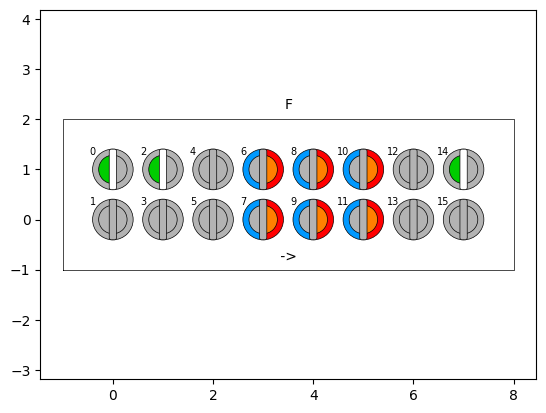

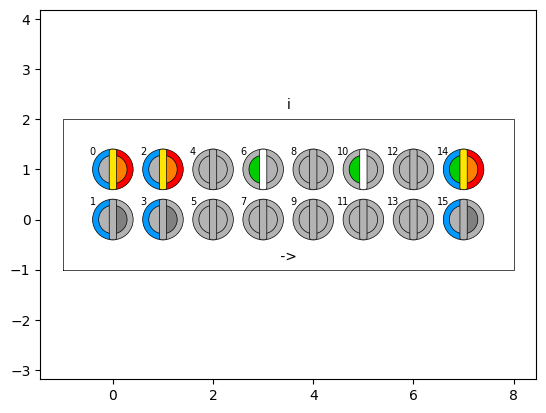

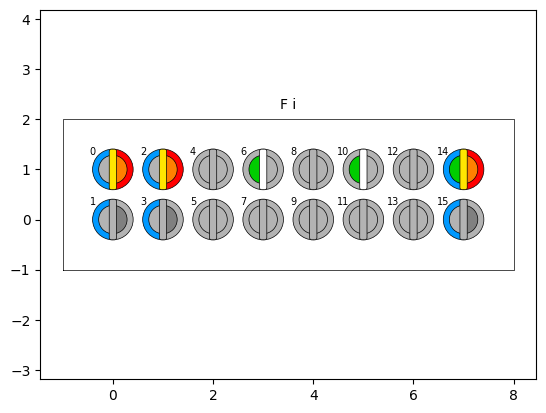

In [5]:
cells.process('F i')
cells.plot('F i')
